### imports


In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tueplots import figsizes
from tueplots import axes
from numpy.linalg import cholesky

from ode_filters.GMP_priors import IWP, taylor_mode_initialization
from ode_filters.ODE_filter_loop import ekf1_sqr_loop, rts_sqr_smoother_loop
from ode_filters.measurement_models import ODEInformation

# plitting specifications
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})
figsize_config = figsizes.aaai2024_half(nrows=1, ncols=2)
plt.rcParams.update(figsize_config)
color_cycler = plt.rcParams["axes.prop_cycle"]
colors = color_cycler.by_key()["color"]

### Example 1: Logistic ODE

$$\dot{x}(t) = x(t)(1-x(t)), \quad x(0) = x_0 = 0.01, \quad t\in [0,10]$$


In [3]:
def vf(x):
    return x * (1 - x)


x0 = np.array([0.01])
t0, t1 = [0, 10]
d = x0.shape[0]

In [5]:
# prior
q = 2
D = d * (q + 1)
xi = 0.5 * np.eye(d)
prior = IWP(q, d, Xi=xi)

# initialize prior
mu_0, Sigma_0_sqr = taylor_mode_initialization(vf, x0, q)
Sigma_0_sqr = np.zeros((D, D))

# domain discretization (unifrom grid)
N = 21
ts, h = np.linspace(t0, t1, N + 1, retstep=True)
A_h = prior.A(h)
Q_h_sqr = cholesky(prior.Q(h), upper=True)
b_h = np.zeros(D)

measure = ODEInformation(vf, d=d, q=q)
g = measure.g
jacobian_g = measure.jacobian_g

z_sequence = np.zeros((N, d))
R_h_sqr = np.eye(d) * 0.0

In [6]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_pred_seq,
    P_pred_seq_sqr,
    G_back_seq,
    d_back_seq,
    P_back_seq_sqr,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop(
    mu_0, Sigma_0_sqr, A_h, b_h, Q_h_sqr, R_h_sqr, g, jacobian_g, z_sequence, N
)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop(
    m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N
)

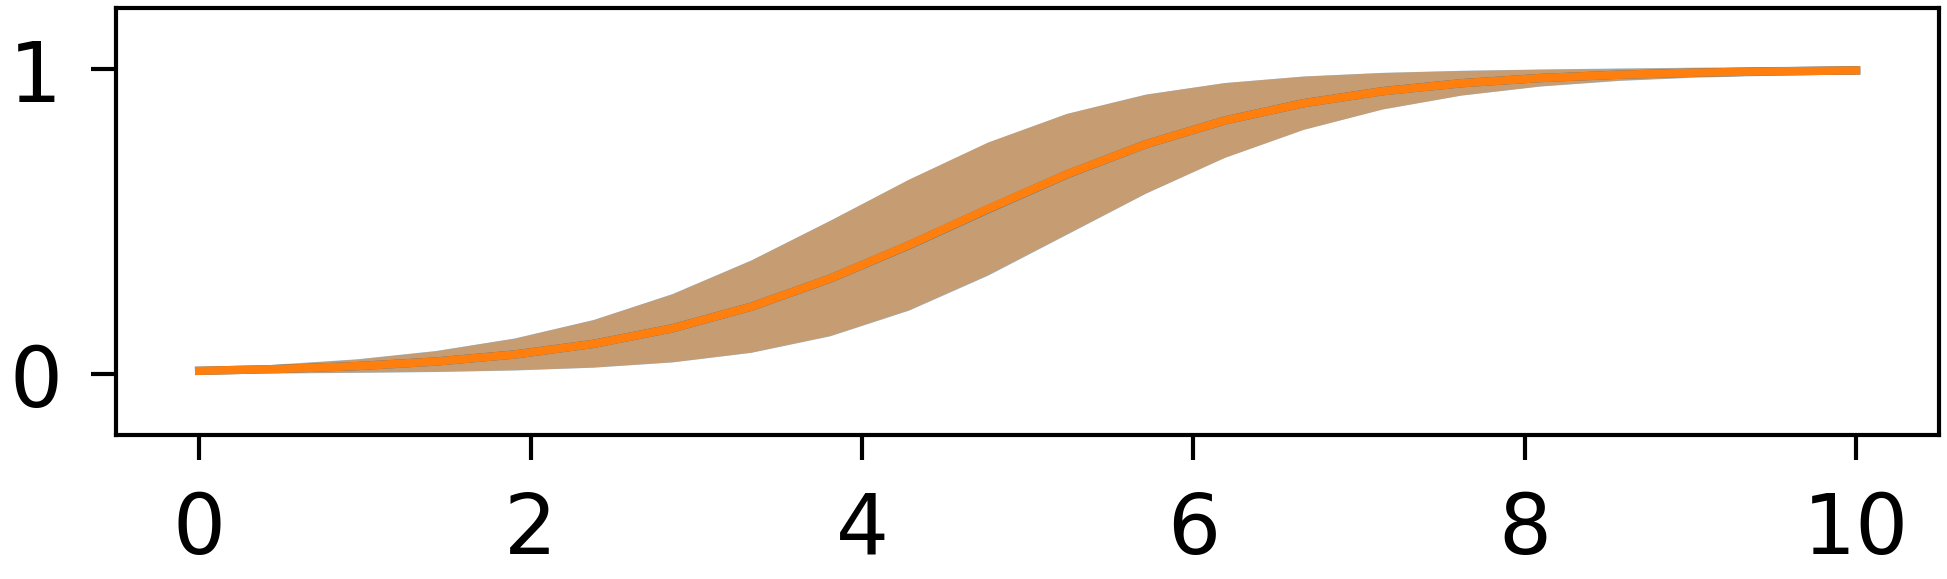

In [7]:
i = 0
plt.figure()
plt.plot(ts, m_seq[:, i])
plt.ylim([-0.2, 1.2])
# plt.ylim([-0.1, 0.4])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, i, i])
plt.fill_between(ts, m_seq[:, i] - margin, m_seq[:, i] + margin, alpha=0.5)
# smoothed results
plt.plot(ts, m_smoothed[:, i])
P_seq = np.matmul(np.transpose(P_smoothed_sqr, (0, 2, 1)), P_smoothed_sqr)
margin = 2 * np.sqrt(P_seq[:, i, i])
plt.fill_between(ts, m_smoothed[:, i] - margin, m_smoothed[:, i] + margin, alpha=0.5)
plt.show()

### Example 2: Lotka Volterra

$$\begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} \alpha x - \beta x y \\ -\gamma y + \delta x y \end{bmatrix}, \quad \begin{bmatrix}\alpha \\ \beta \\ \gamma \\ \delta  \end{bmatrix} = \begin{bmatrix} 2/3 \\ 4/3 \\ 1 \\1 \end{bmatrix}, \quad \begin{bmatrix}x_0 \\ y_0 \end{bmatrix} = \begin{bmatrix}1, 1\end{bmatrix}, \quad t \in [0, 30]$$


In [13]:
# ODE x_dot = vf(x)
def vf(x):
    return jnp.array([2.0 * x[0] / 3.0 - 4.0 * x[0] * x[1] / 3.0, x[0] * x[1] - x[1]])


# Initial value and dims
x0 = np.array([1.0, 1.0])
t0, t1 = [0.0, 30.0]
d = x0.shape[0]

In [14]:
# prior
q = 2
D = d * (q + 1)
xi = 1.0 * np.eye(d)
prior = IWP(q, d, Xi=xi)

# initialize prior
mu_0 = taylor_mode_initialization(vf, x0, q)
Sigma_0_sqr = np.zeros((D, D))

# domain discretization (unifrom grid)
N = 60
ts, h = np.linspace(t0, t1, N + 1, retstep=True)
A_h = prior.A(h)
Q_h_sqr = cholesky(prior.Q(h), upper=True)
b_h = np.zeros(D)

# define projection matrices
E0 = np.zeros(q + 1)
E0[0] = 1.0
E1 = np.zeros(q + 1)
E1[1] = 1.0
E0 = np.kron(E0, np.eye(d))
E1 = np.kron(E1, np.eye(d))


def g(X):
    g_ODE = E1 @ X - vf(E0 @ X)
    return g_ODE


jacobian_g = jax.jacfwd(g)
z_sequence = np.zeros((N, d))
R_h_sqr = np.eye(d) * 0.0

In [8]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_pred_seq,
    P_pred_seq_sqr,
    G_back_seq,
    d_back_seq,
    P_back_seq_sqr,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop(
    mu_0, Sigma_0_sqr, A_h, b_h, Q_h_sqr, R_h_sqr, g, jacobian_g, z_sequence, N
)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop(
    m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N
)

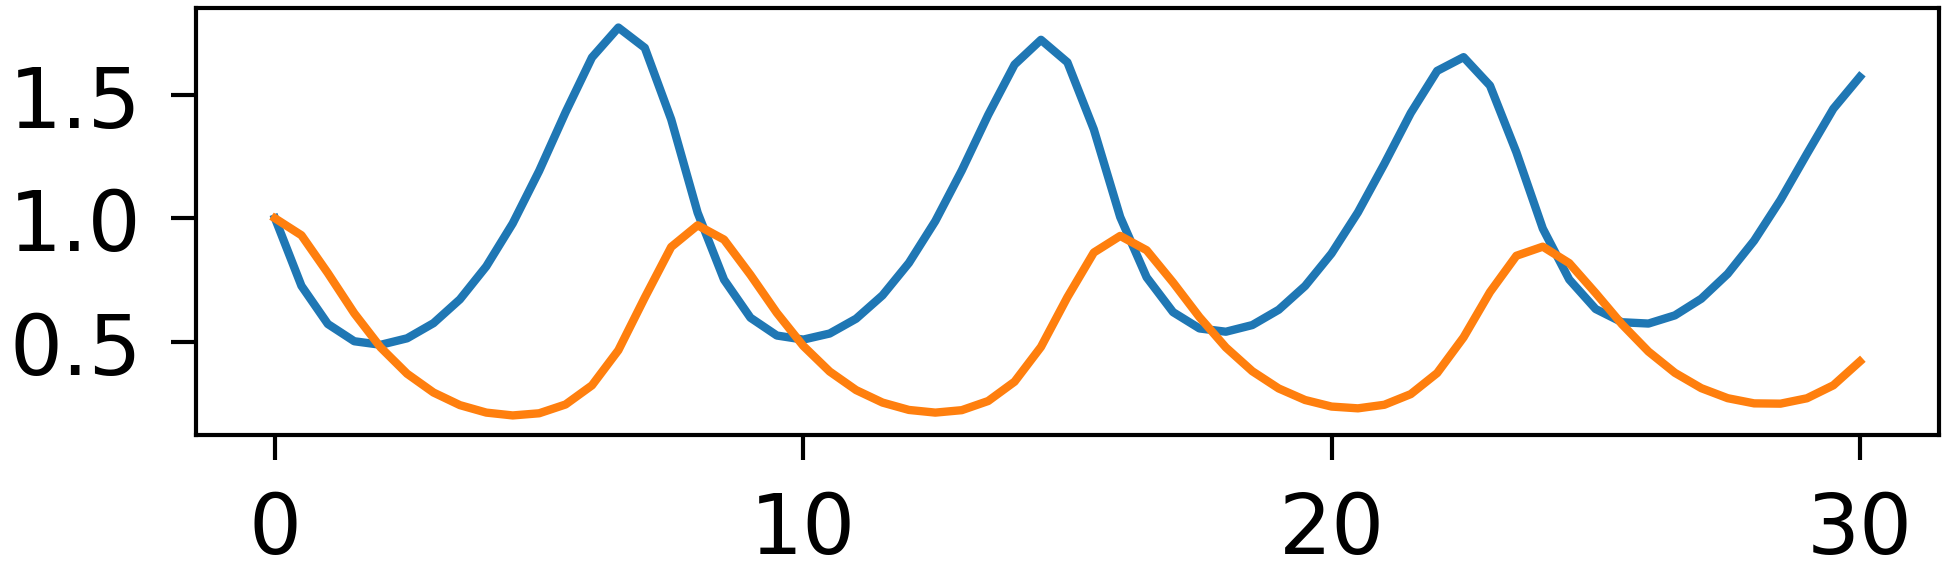

In [9]:
i = 2
plt.figure()
plt.plot(ts, m_seq[:, :i])
# plt.ylim([-0.2, 1.2])
# plt.ylim([-0.1, 0.4])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(np.diagonal(P_seq[:, :i, :i], axis1=1, axis2=2))
# plt.fill_between(ts, m_seq[:, :i] - margin, m_seq[:, :i] + margin, alpha=0.5)
plt.show()

### Example 3: SIR model

$$\begin{bmatrix} S \\ I \\ R \end{bmatrix} = \begin{bmatrix} -\beta IS \\ \beta IS - \gamma I \\ \gamma I  \end{bmatrix}, \quad \begin{bmatrix} \beta \\ \gamma \end{bmatrix} = \begin{bmatrix} 0.5 \\ 0.1  \end{bmatrix}, \quad \begin{bmatrix} S_0 \\ I_0 \\ R_0 \end{bmatrix} = \begin{bmatrix} 0.99 \\ 0.01 \\ 0 \end{bmatrix}, \quad t \in [0,100]$$


In [10]:
def vf(x, beta=0.5, gamma=0.1):
    return jnp.array(
        [-1 * beta * x[0] * x[1], beta * x[0] * x[1] - gamma * x[1], gamma * x[1]]
    )


# Initial value and dims
x0 = np.array([0.99, 0.01, 0.0])
t0, t1 = [0.0, 100.0]
d = x0.shape[0]

In [11]:
# prior
q = 2
D = d * (q + 1)
xi = 1.0 * np.eye(d)
prior = IWP(q, d, Xi=xi)

# initialize prior
mu_0 = taylor_mode_initialization(vf, x0, q)
Sigma_0_sqr = np.zeros((D, D))

# domain discretization (unifrom grid)
N = 100
ts, h = np.linspace(t0, t1, N + 1, retstep=True)
A_h = prior.A(h)
Q_h_sqr = cholesky(prior.Q(h), upper=True)
b_h = np.zeros(D)

# define projection matrices
E0 = np.zeros(q + 1)
E0[0] = 1.0
E1 = np.zeros(q + 1)
E1[1] = 1.0
E0 = np.kron(E0, np.eye(d))
E1 = np.kron(E1, np.eye(d))


def g(X):
    g_ODE = E1 @ X - vf(E0 @ X)
    return g_ODE


jacobian_g = jax.jacfwd(g)
z_sequence = np.zeros((N, d))
R_h_sqr = np.eye(d) * 0.0

In [12]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_pred_seq,
    P_pred_seq_sqr,
    G_back_seq,
    d_back_seq,
    P_back_seq_sqr,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop(
    mu_0, Sigma_0_sqr, A_h, b_h, Q_h_sqr, R_h_sqr, g, jacobian_g, z_sequence, N
)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop(
    m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N
)

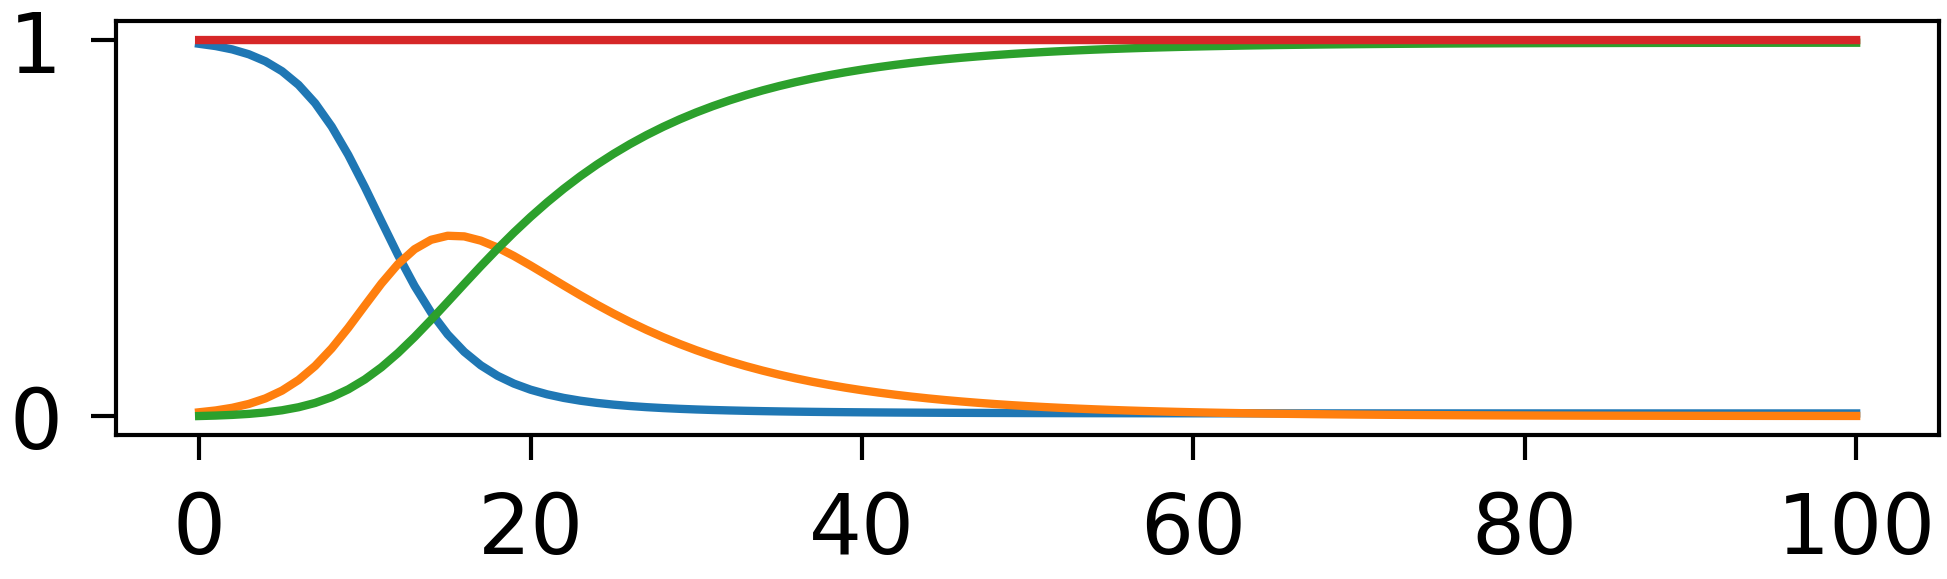

In [13]:
i = 3
plt.figure()
plt.plot(ts, m_seq[:, :i])
# plt.ylim([-0.2, 1.2])
# plt.ylim([-0.1, 0.4])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(np.diagonal(P_seq[:, :i, :i], axis1=1, axis2=2))
# plot the poplulation
plt.plot(ts, m_seq[:, :i].sum(axis=1))
plt.show()

### Example 4: Preconditioned Logistic


In [2]:
from ode_filters.GMP_priors import IWP_precond
from ode_filters.ODE_filter_loop import (
    ekf1_sqr_loop_preconditioned,
    rts_sqr_smoother_loop_preconditioned,
)


In [3]:
def vf(x):
    return x * (1 - x)


x0 = np.array([0.01])
t0, t1 = [0, 10]
d = x0.shape[0]

In [4]:
q = 2
D = d * (q + 1)
xi = 0.5 * np.eye(d)
prior = IWP_precond(q, d, Xi=xi)

# initialize prior
mu_0 = taylor_mode_initialization(vf, x0, q)
Sigma_0_sqr = np.zeros((D, D))

# domain discretization (unifrom grid)
N = 21
ts, h = np.linspace(t0, t1, N + 1, retstep=True)
A_bar = prior.A()
Q_sqr_bar = cholesky(prior.Q(), upper=True)
b_bar = np.zeros(D)
T_h = prior.T(h)

# define projection matrices
E0 = np.zeros(q + 1)
E0[0] = 1.0
E1 = np.zeros(q + 1)
E1[1] = 1.0
E0 = np.kron(E0, np.eye(d))
E1 = np.kron(E1, np.eye(d))


# observation model
def g(X):
    g_ODE = E1 @ X - vf(E0 @ X)
    return g_ODE


jacobian_g = jax.jacfwd(g)
z_sequence = np.zeros((N, d))
R_h_sqr = np.eye(d) * 0.0

In [ ]:
# apply ODE filter
(
    m_seq,
    P_seq_sqr,
    m_seq_bar,
    P_seq_sqr_bar,
    m_pred_seq_bar,
    P_pred_seq_sqr_bar,
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop_preconditioned(
    mu_0,
    Sigma_0_sqr,
    T_h,
    A_bar,
    b_bar,
    Q_sqr_bar,
    R_h_sqr,
    g,
    jacobian_g,
    z_sequence,
    N,
)

# apply ODE smoother
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop_preconditioned(
    m_seq[-1],
    P_seq_sqr[-1],
    m_seq_bar[-1],
    P_seq_sqr_bar[-1],
    G_back_seq_bar,
    d_back_seq_bar,
    P_back_seq_sqr_bar,
    N,
    T_h,
)

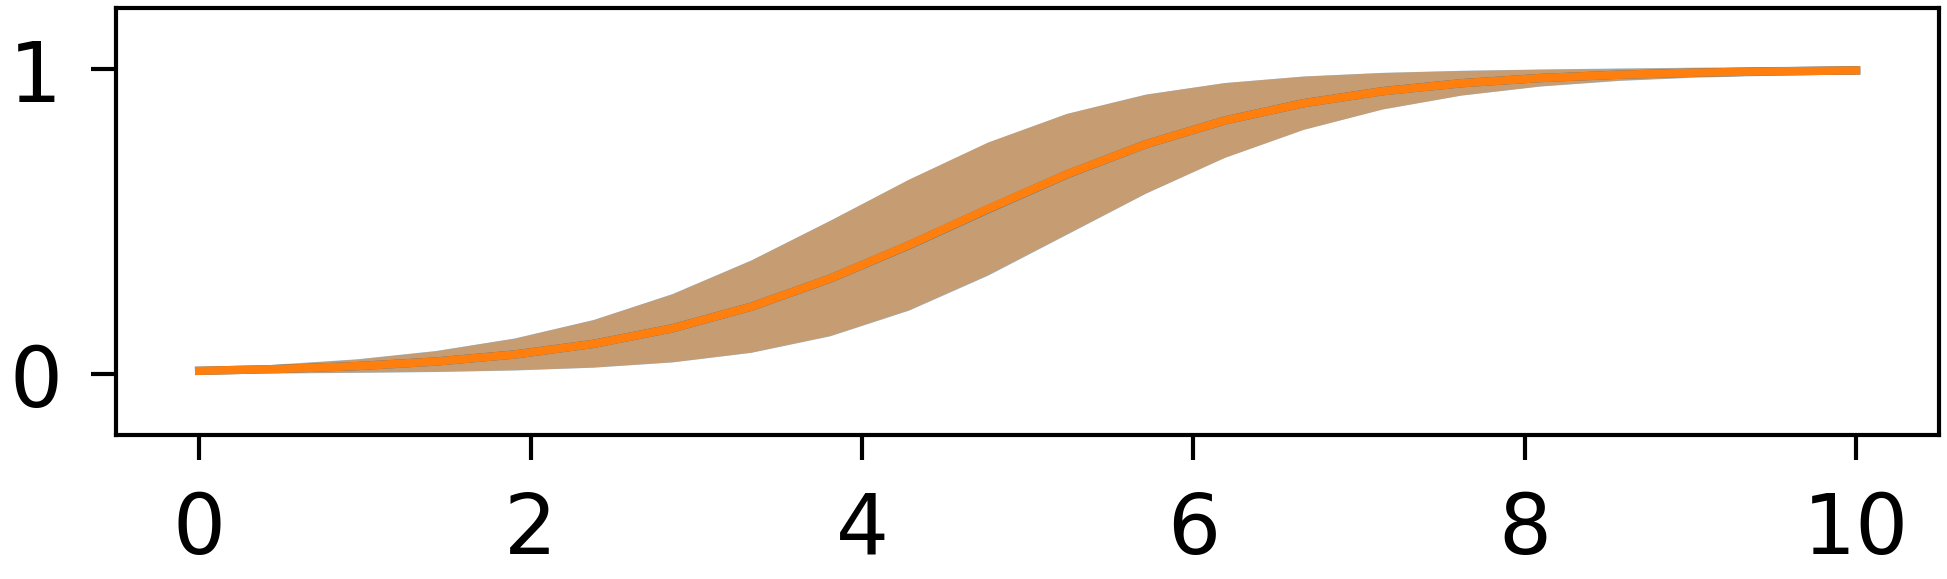

In [6]:
i = 0
plt.figure()
plt.plot(ts, m_seq[:, i])
plt.ylim([-0.2, 1.2])
# plt.ylim([-0.1, 0.4])
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, i, i])
plt.fill_between(ts, m_seq[:, i] - margin, m_seq[:, i] + margin, alpha=0.5)
# smoothed results
plt.plot(ts, m_smoothed[:, i])
P_seq = np.matmul(np.transpose(P_smoothed_sqr, (0, 2, 1)), P_smoothed_sqr)
margin = 2 * np.sqrt(P_seq[:, i, i])
plt.fill_between(ts, m_smoothed[:, i] - margin, m_smoothed[:, i] + margin, alpha=0.5)
plt.show()